<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [1.1 60 Minutes to Pyomo: An Energy Storage Model Predictive Control Example](https://ndcbe.github.io/CBE60499/01.01-Pyomo-Nuts-and-Bolts.html) | [Contents](toc.html) | [2.0 Optimization Modeling with Applications](https://ndcbe.github.io/CBE60499/02.00-Optimization-Modeling.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [1]:
# IMPORT DATA FILES USED BY THIS NOTEBOOK
import os,  requests

file_links = [("data/Prices_DAM_ALTA2G_7_B1.csv", "https://ndcbe.github.io/CBE60499/data/Prices_DAM_ALTA2G_7_B1.csv")]

# This cell has been added by nbpages. Run this cell to download data files required for this notebook.

for filepath, fileurl in file_links:
    stem, filename = os.path.split(filepath)
    if stem:
        if not os.path.exists(stem):
            os.mkdir(stem)
    if not os.path.isfile(filepath):
        with open(filepath, 'wb') as f:
            response = requests.get(fileurl)
            f.write(response.content)


# 1.2 Pyomo Mini-Project: Receding Horizon Stochastic Control

**Deadline:** Friday, March 5, 2021

## 1.2.1 Assignment Goals

The **primary purpose** of this assignment is to give you **hands-on-keyboard experience** with optimization modeling and analysis. In this assignment, I incorporated many of the best practices I share with my Ph.D. students during their first year using Pyomo for research. Specifically:
* Planning is the most important (and often most overlooked step) in computer programming. Two best practices are to (1) write pseudocode and (2) write the optimization model on paper and perform degree of freedom analysis before you use the computer. We practiced tip (2) in class. If you cannot do (1) and (2), no amount of Googling Pyomo/Python syntax will save you.
* Functions (or classes) allow us to reuse most of our code. Below I gave you function definitions and doc strings to show you a good way to "modularize" this analysis. Once the functions defined below work, performing the analysis is easy.
* Solving your optimization problem a few times is (often) not a sufficient research result. Who cares? Application-driven research is all about the analysis. Optimization is a tool to better answer analysis questions. By giving you >50% of the code for this assignment, I am intentionally emphasizing the analysis (not just coding).  You will see we can take a really simple optimization model and ask/answer some interesting analysis questions.

You should start this assignment early. Almost everyone will make at least one Python/Pyomo syntax mistake. Give yourself plenty of time to ask questions on Slack. Please also be generous with helping your classmates. This assignment (and grades in general in this class) is not a competition. You are welcome (encouraged!) to post screenshots of your code in Slack when asking/answering questions. Please refrain from posting your discussion responses. You are welcome to discuss the analysis questions on Slack; everyone should answer the discussion questions in their own words.

In [2]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.download_data(['Prices_DAM_ALTA2G_7_B1.csv'])

In [3]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ca_data = pd.read_csv('./data/Prices_DAM_ALTA2G_7_B1.csv',names=['price'])

In [5]:
def prepare_data_array(day=2,num_days=8):
    ''' Prepare numpy array of prices
    
    Arguments:
        day: day to start (0 = January 1, 2015)
        num_days: numbers of days to include in the vector
        
    Returns:
        numpy array of prices
    '''

    return ca_data["price"][(day)*24:24*(day+num_days)].to_numpy()

In the previous notebook, we considered model predictive control (MPC) of a battery energy storage system interacting with the electricity market. In essence, we posed an optimization problem:

*Given a forecasting for energy prices, what charging and discharging strategy maximizes net market revenue?*

In this homework mini-project, you will consider two modifications to make the example more realistic:
1. Add a constraint to prevent simultanous charging and discharging.
1. Receding horizon control
2. Uncertainty

The goal is to help you develop Python and Pyomo programming skills.

## 1.2.2 Model Refinement and Code Reorganization

### 1.2.2.1 Revised Model

Propose a new mathematical model that includes a constraint to prevent charging and discharging. Hint: using either integer variables or a disjunction will ensure the objective and constraints remaining linear.

Below is the model description copied from our in-class example. **Please edit** such that this notebook describes your complete new model.

**Sets**

Timesteps: $\mathcal{T} = \{0, 1, ..., N\}$
    
Timesteps without the initial time: $\mathcal{T}' = \{1, ..., N\}$

**Variables**
* $E_t$, energy stored in battery at time $t$, units: MWh
* $d_t$, battery discharge power (sold to market) during time interval [t-1, t), units: MW
* $c_t$, battery charge power (purchased from the market) during time interval [t-1, t), units: MW
* $y_t$, binary: 1 if charging is allowed during time interval [t-1, t), 0 if charging is not allowed during this time interval, units: dimensionless

**Parameters**
* $\pi_t$: Energy price during time interval [t-1, t), units: \$/MW
* $\eta$: Round trip efficiency, units: dimensionless
* $c_{max}$ Maximum charge power, units: MW
* $d_{max}$ Maximum discharge power, units: MW
* $E_{max}$ Maximum storage energy, units: MWh
* $E_{0}$ Energy in storage at time $t=0$, units: MWh
* $\Delta t = 1$ hour, Timestep for grid decisions and prices (fixed)

**Optimization Problem**
$$
\begin{align*}
    \max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} \Delta t (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + \Delta t \left( c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}} \right), ~~ \forall ~ t \in \mathcal{T}' \\
    & E_{0} = E_{N} \\
    & 0 \leq c_{t} \leq c_{max}y_t, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}(1-y_t), ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$$

### 1.2.2.2 Degree of Freedom Analysis

Perform degree of freedom analysis. Identify:
1. Total number of continous variables
2. Total number of integer variables (or disjunctions if using)
3. Total number of equality constraints
4. Total number of inequality constraints
5. Degrees of freedom

Tip: perform this on paper then typeset below.

**Number of continous variables:** 3N+1; these are (N+1) $E_t$, N $d_t$, and N $c_t$

**Number of integer variables:** N; these are the N $y_t$

**Number of equality constraints:** N+2; these are the 1 periodic boundary condition, 1 fixation of $E_0$ ,and the N energy balance constraints (Note: I know $E_0$ is given as a parameter, not a variable, but in my code below, I will make it a variable that is constrained to be equal to the parameter)

**Number of inequality constraints:** 3N; these are N of each of the three inequalities shown
    
**Degrees of freedom.** The way that the problem is formulated, it has 3N-1 degrees of freedom according to the simple formula given in notebook 1.01 that neglects inequality constraints and bounds, because 4N+1 variables minus N+2 equality constraints equals 3N-1 degrees of freedom.  However, these degrees of freedom are not entirely free or entirely independent of each other, due to their bounds and inequality constraints.  The problem could have been formulated with net charging rate as a variable instead of charging rate and discharging rate, likely reducing the degrees of freedom, but c and d are referrenced later in the project code given so I did not make this simplification.  Such a reduction in degrees of freedom would likely also be seen for this formulation if I were to account for the inequality constraints, but I don't think we have been taught how to do that yet.

### 1.2.2.3 Python Code

Programmers organize their code into functions, often following the rule "1 task/action = 1 function". Here are a few of the reasons you should always do this:
1. Functions make your code easier to use
2. More specifically, functions force you to abstract/generalize your code
3. Writing doc strings (required for this course!) forces you to document your code and think about the structure.
4. Functions allow your code to best tested piece by piece

To show you how to do this, we have provided skeletons for several functions in this assignment. Based on the doc string, complete the functions.

In [6]:
def build_model(price_data, horizon_length, include_pbc=True, include_disjunction=True):
    '''
    Builds HORIZON pyomo model
    
    Inputs:
    price_data: dictionary of price data
    horizon_length: number of timesteps to evaluate
    include_pbc: Boolean, include periodic boundary condition constraint
    
    Returns:
    m: HORIZON pyomo model
    '''
    
    m = pyo.ConcreteModel()
    
    # Begin Solution
    
    m.N = pyo.Param(initialize=horizon_length)
    
    # Sets
    m.T = pyo.RangeSet(0,m.N) # Timesteps
    m.Tprime = pyo.RangeSet(m.N) # Timesteps without zero
    
    # Parameters
    m.pi = pyo.Param(m.Tprime, initialize=price_data, mutable=True)
    eta = 0.88
    m.sqrteta = pyo.Param(initialize=eta**0.5, mutable=True)
    m.cmax = pyo.Param(initialize=1.0, mutable=True)
    m.dmax = pyo.Param(initialize=1.0, mutable=True)
    m.Emax = pyo.Param(initialize=4.0, mutable=True)
    m.E0 = pyo.Param(initialize=0, mutable=True)
    m.tstep = pyo.Param(initialize=1.0, mutable=True)
    
    
    
    # Variables
    m.E = pyo.Var(m.T, within=pyo.NonNegativeReals, bounds=(0,m.Emax))
    m.d = pyo.Var(m.Tprime, within=pyo.NonNegativeReals, bounds=(0,m.dmax))
    m.c = pyo.Var(m.Tprime, within=pyo.NonNegativeReals, bounds=(0,m.cmax))
    m.y = pyo.Var(m.Tprime, within=pyo.Binary)
    
    # Objective
    @m.Objective(sense=pyo.maximize)
    def profitobj(m):
        return sum(m.pi[t]*m.tstep*(m.d[t]-m.c[t]) for t in m.Tprime)
    
    # Constraints
    @m.Constraint()
    def ic_constraint(m):
        return m.E[0] == m.E0
    
    if include_pbc:
        @m.Constraint()
        def pbc_constraint(m):
            return m.E[m.N] == m.E0
    
    @m.Constraint(m.Tprime)
    def ebalance(m, t):
        return m.E[t] == m.E[t-1] + m.tstep*(m.c[t]*m.sqrteta - m.d[t]/m.sqrteta)
    
        
    if include_disjunction:
        @m.Constraint(m.Tprime)
        def chargerate_constraint(m,t):
            return m.c[t] <= m.y[t]*m.cmax
        @m.Constraint(m.Tprime)
        def dischargerate_constraint(m,t):
            return m.d[t] <= (1-m.y[t])*m.dmax
    
    
    # End Solution
    
    return m


In [7]:
def extract_solution(m):
    '''
    Function to extract the solution from the solved pyomo model
    
    Inputs:
        m: Solved pyomo model
    
    Outputs:
        c_control: numpy array of charging power values, MW
        d_control: numpy array of discharging power values, MW
        E_control: numpy array of energy stored values, MWh
        t: numpy array of time indices from the Pyomo model, hr
    '''
    
    c_control = np.empty(pyo.value(m.N))
    d_control = np.empty(pyo.value(m.N))
    E_control = np.empty(pyo.value(m.N))
    t = np.empty(pyo.value(m.N))

    # Tip: We added a negative sign to d to help with plotting in the code discussed during class.
    # Begin Solution
    for i in range(t.size):
        c_control[i] = pyo.value(m.c[i+1])
        d_control[i] = pyo.value(m.d[i+1])
        E_control[i] = pyo.value(m.E[i+1])
        t[i] = i+1
    
    # End Solution
    
    return c_control, d_control, E_control, t

In [8]:
def plot_solution(c, d, E, t=None):
    '''
    Function to plot the solution of the HORIZON problem
    
    Inputs:
        c_control: numpy array of charging power values, MW
        d_control: numpy array of discharging power values, MW
        E_control: numpy array of energy stored values, MWh
        t: numpy array of time indices from the Pyomo model, hr. (default=None)
    
    Actions. Creates the following plots: 
        State of charge (energy) verus time
        Power to the grid verus time
    '''
    
    # Plot the state of charge (E)
    plt.figure()

    N = len(c)
    assert N > 0, "Input t must have length greate than 0"
    assert len(d) == N, "All inputs should be the same length"
    assert len(E) == N, "All inputs should be the same length"
    
    if t is None:
        # add E0
        t = np.array(range(1,N+1))
        t_ = np.array(range(0,N+1))
    else:
        t_ = np.concatenate(([0],  t))

    # Begin Solution
    plt.plot(t,E,'b.-')
    plt.xlabel('Time (hr)')
    plt.ylabel('Energy in Storage (MWh)')
    plt.grid(True)
    plt.show()
    
    # End Solution
    
    # Plot charging/discharging plot
    plt.figure()

    # double up first data point to make the step plot
    c_control_ = np.concatenate(([c[0]],  c))
    d_control_ = np.concatenate(([d[0]],  d))

    plt.step(t_,c_control_,'r.-',where='pre')
    plt.step(t_,-d_control_,'g.-',where='pre')
    plt.xlabel('Time (hr)')
    plt.ylabel('Power from Grid (MW)')
    plt.grid(True)
    plt.show()
    
    return

### 1.2.2.4 Optimal Control Over 3 Day Horizon

Now let's use our functions for some analysis. Calculate the optimal battery operation strategy over 3 days starting on January 4, 2015.

In [9]:
three_days = prepare_data_array(4,3)

#### 1.2.2.4.1 Original Model

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      290
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      217
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      217
                     variables with only upper bounds:        0
Total 

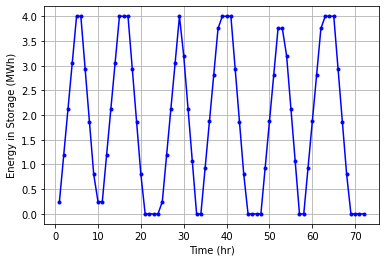

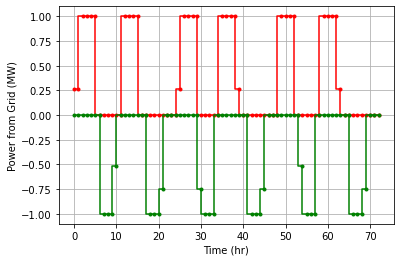

In [10]:
# Start solution
# Convert three_days to dict
price_dict = {(x+1): three_days[x] for x in range(three_days.size)}
solver_ipopt = pyo.SolverFactory('ipopt')
model_original = build_model(price_data=price_dict, horizon_length=three_days.size,include_disjunction=False)
results_original_ipopt = solver_ipopt.solve(model_original, tee=True)
c_control_og, d_control_og, E_control_og, t = extract_solution(model_original)
plot_solution(c_control_og, d_control_og, E_control_og)



#### 1.2.2.4.2 With Constraint Enforcing No Simultaneous Charging or Discharging

Ipopt 3.13.3: 
==> Warning: Treating 72 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      290
Number of nonzeros in inequality constraint Jacobian.:      288
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      289
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      289

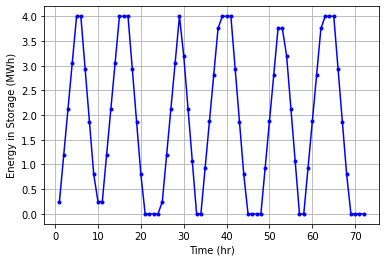

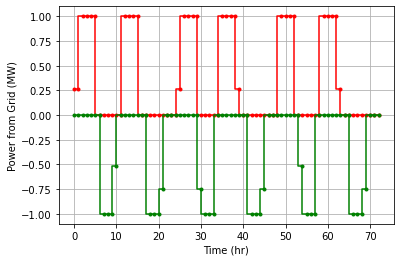

In [11]:
# Start solution
# Convert three_days to dict
price_dict = {(x+1): three_days[x] for x in range(three_days.size)}
solver_ipopt = pyo.SolverFactory('ipopt')
model_disj = build_model(price_data=price_dict, horizon_length=three_days.size)
results_disj_ipopt = solver_ipopt.solve(model_disj, tee=True)
c_control_disj, d_control_disj, E_control_disj, t = extract_solution(model_disj)
plot_solution(c_control_disj, d_control_disj, E_control_disj)

#### 1.2.2.4.3 Comparison

Write Python code below to compare the solutions. Print out any timesteps where the charge, discharge, and energy profiles are different by more than 10$^{-4}$ MW (or MWh).

In [12]:
def compare_solutions(solution1,solution2):
    '''
    Function to compare outputs between the original model and model with disjuncutions
    
    Inputs:
    original: list of original charging/discharging data
    disjunction: list of disjunction model results charging/discharging data
    t: list of timesteps
    
    Action:
    prints same/different + timestep
    '''
    
    assert len(solution1) == len(solution2), "solution 1 and solution2 must be the same length"
    
    n = len(solution1)
    
    # Begin Solution
    
    for i in range(n):
        if abs(solution1[i] - solution2[i]) > 1e-4:
            print(i+1, solution1[i], solution2[i], solution2[i] - solution1[i])
    print('')
    print('Total', sum(solution1), sum(solution2), sum(solution2) - sum(solution1))
    # End Solution
      
    
    print("Done.")

In [13]:
# Charge
compare_solutions(c_control_og, c_control_disj)


Total 25.05605716166524 25.05605717395981 1.2294570694848517e-08
Done.


In [14]:
# Discharge
compare_solutions(d_control_og, d_control_disj)


Total 22.04933039078816 22.049330393070154 2.281993261021853e-09
Done.


In [15]:
# Energy
compare_solutions(E_control_og, E_control_disj)


Total 135.2079575628461 135.20795769161919 1.2877308108727448e-07
Done.


## 1.2.3 Receding Horizon Control

We now have functions to build, solve, and analyze the battery problem for a single problem. Now we can consider receeding horizon control.

*Please ask questions during class. You do not need to turn anything in for this section.*

Nomenclature: Let $u^*_{i}$ represent the optimal control action from time $t=i$ to $t=i+1$. For the battery system, $u_{i} = [c_i, d_i]^{T}$ (charging and discharging).

Algorithm:
1. Consider time $t=m$. 
2. Compute the optimal control actions $u^*=[u^*_m, u^*_{m+1}, ..., u^*_{m+N-1}]^T$ from time $t=m$ until $t=N+m$ where $N$ is the length of the planning horizon. In our battery example, we considered $N = 24$.
3. Simulate the system for one timestep using control action $u^*_{m}$.
4. (Optional). Update the system model or forecasts using new observations.
5. Step $t=m+1$ and goto Step 2.

### 1.2.3.1 Write Pseudocode

Pseudocode is an important planning tool for complex computer programs. The idea is to write out the code on paper or a whiteboard using generic programming syntax. As an example, consider calculating the 3rd through 10th elements of the Fibonacci sequence:

```
# Governing equation where f[i] is the ith element of the sequence
# f[i] = f[i-1] + f[i-2]

# Algorithm:

# Previous previous number in the sequence, f[i-2]
n_2prev = 1

# Previous number in the sequence, f[i-1]
n_1prev = 1

# Set counter
j = 3

while j <= 10 do:
    # Apply Fib. formula
    n = n1_prev + n2_prev
    
    # Print to screen
    print(n)
    
    # Shift history.
    # Previous number becomes previous previous number
    n2prev = n1prev
    
    # Current number becomes previous number
    n1prev = n
    
    # Increment counter
    j = j + 1
```

Here we sketched out the main algorithm (with comments!) in generic syntax. We did not worry about the correct way to write a while loop in Python. Once we figure out the algorithm we can worry about those details.

Write pseudocode for the receding horizon control example on paper or a whiteboard. Your algorithm should include the following main steps:
1. Load price data from a text file
2. Loop over timesteps. Keep track of implemented control actions (charge and discharge), battery SOC, and net revenue.
3. Make a plot of battery SOC and control actions that were actually implemented.

Scan your pseudocode as a PDF and turn in via Gradescope.

### 1.2.3.2 Python Code

Tip: You should use the same `create_model` function throughout the assignment. In your model, define `price` to be a mutable parameter. This means we can just update the Pyomo model in the function below. We do not need to recreate it.

In [16]:
def update_model(model, new_price_data, new_E0):
    """ Update the Pyomo model with new price data
    
    Arguments:
        model: pyomo model
        new_price_data: numpy array or list containing price data
        new_E0: (float) value for initial battery charge
    """
    
    # Start Solution
    for x in range(len(new_price_data)):
        model.pi[x+1] = new_price_data[x]
    model.E0 = new_E0

In [17]:
def receding_horizon_simulation(price_data, simulation_length, num_hours, include_pbc=True,verbose=True):  
    '''
    Perform receding horizon simulation
    
    Inputs:
        price_data: numpy array price data for entire time period of interest
        simulation_length: number of total hours to evaluate
        num_hours: horizon length for each optimization problem
        include_pbc: boolean, include periodic boundary condition
        verbose: boolean, if true, print out message each hour
    
    Returns:
        c_control: charging decision implemented
        d_control: discharging decision implemented
        E_control: state-of-charge profile
        revenue_control: total revenue over simulation horizon
    
    '''
    
    # Check input data length
    assert len(price_data) >= simulation_length + num_hours, "Input price data is too short"
    
    assert simulation_length > 0, "Must evaluate more than 0 days"
    
    assert num_hours > 0, "Must consider planning horizon longer than 0 days"

    nS = simulation_length
        
    ## Preallocate vectors to store results
    c_control = np.empty(nS)
    d_control = np.empty(nS)
    E_control = np.empty(nS)
    revenue_control = np.empty(nS)

    # Begin Solution
    t0 = 0
    solver = pyo.SolverFactory('ipopt')
    # set horizon price array
    horizon_prices = price_data[t0:t0+num_hours]
    # convert to dict
    horizon_dict = {(x+1):horizon_prices[x] for x in range(len(horizon_prices))}
    # create model
    m = build_model(horizon_dict, num_hours, include_pbc)
    # loop of simulation_length solutions
    for i in range(simulation_length):
        # solve model for current horizon
        solver.solve(m)
        # record variable and objective values for first step of horizon
        c_control[i] = pyo.value(m.c[1])
        d_control[i] = pyo.value(m.d[1])
        E_control[i] = pyo.value(m.E[1])
        # The docstring gave the wrong definition of revenue_control, and would have it defined as in the comment line below
        # revenue_control[i] = pyo.value(m.profitobj)
        # I know that because it's inconsistent with the definition implied by the code given in the uncertainty section
        # It should actually be assigned as follows
        revenue_control[i] = horizon_prices[0]*(d_control[i]-c_control[i])
        if verbose:
            print("Hour {}: {} MW from grid; battery holding {} MWh".format(i+1,c_control[i]-d_control[i], E_control[i]))
        # increment horizon start
        t0 = t0 + 1
        # update horizon price array
        horizon_prices = price_data[t0:t0+num_hours]
        # update model
        update_model(m, horizon_prices, E_control[i])
        
    
    
    # End Solution

    return c_control, d_control, E_control, revenue_control

### 1.2.3.3 Simulate Performance Over 3 Days

Perform receding horizon control for the first 3 days in January 2015. Make a plot to show the implemented control action.

Tips:
* The implemented control action is a concationation of the first timestep for each optimization problem.
* How can you resuse the plot function above?

In [18]:
three_days = prepare_data_array(0,4)

In [19]:
# Tip: do not overwrite these results. We will use them later.
# If you reuse this code, change the variable names used to save the results.
c_control_pbc, d_control_pbc, E_control_pbc, revenue_control_pbc = receding_horizon_simulation(three_days, 24*3, 
                                                                               24, include_pbc=True,
                                                                              verbose=True)

Hour 1: 0.0 MW from grid; battery holding 7.257435359162938e-10 MWh
Hour 2: 0.0 MW from grid; battery holding 3.50958896632434e-09 MWh
Hour 3: 0.9999999866619921 MW from grid; battery holding 0.9380831530856943 MWh
Hour 4: 1.0 MW from grid; battery holding 1.8761663221036358 MWh
Hour 5: 0.27272724660552505 MW from grid; battery holding 2.132007167304637 MWh
Hour 6: 0.0 MW from grid; battery holding 2.1320071669578735 MWh
Hour 7: -0.9999999882229036 MW from grid; battery holding 1.0660035887726746 MWh
Hour 8: -1.0 MW from grid; battery holding 0.0 MWh
Hour 9: -4.694242601861028e-10 MW from grid; battery holding 0.0 MWh
Hour 10: 0.0 MW from grid; battery holding 4.283065849314467e-10 MWh
Hour 11: 0.2640142790951685 MW from grid; battery holding 0.2476673574744647 MWh
Hour 12: 1.0 MW from grid; battery holding 1.1857505259742929 MWh
Hour 13: 1.0 MW from grid; battery holding 2.123833696701688 MWh
Hour 14: 1.0 MW from grid; battery holding 3.061916867625161 MWh
Hour 15: 1.0 MW from grid; b

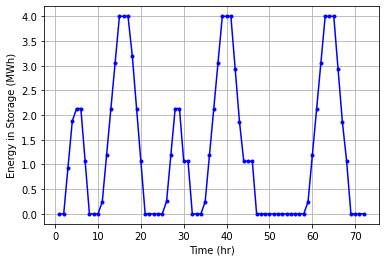

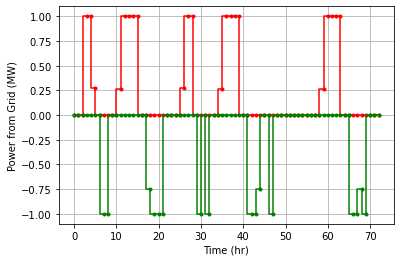

In [20]:
plot_solution(c_control_pbc, d_control_pbc, E_control_pbc)

### 1.2.3.4 Impact of Horizon Length

Repeat the sensitivity analysis for horizon lengths of N=2 through N=48. For each simulation, compute the following:
1. Revenue from first 30 days
2. Total energy purchased from the market during the first 30 days
3. Total energy sold to the market during the first 30 days
4. Total computation time

In [21]:
# Study this cell to see how to time calculations in Python
import time

time_start = time.perf_counter()
first_month = prepare_data_array(0,34)
time_elapsed = (time.perf_counter() - time_start)

print("Elapsed Time",time_elapsed,"s")

Elapsed Time 0.0007793000004312489 s


In [22]:
rev = []
charge = []
discharge = []
timer = []

# Tip: This will take a few minutes to finish. While developing your solutions, 
# only simulate the first few values of N. This will be helpful if you need to
# restart your kernel and rerun the cells. Once you are happy with your code
# for the entire assignment, you can set N to the values given here then
# restart and run all.
N = [2, 4, 6, 8, 12, 24, 36, 48]

# Start Solution
for hlen in N: # remove slice once finished initial testing
    time_start = time.perf_counter()
    c_control_pbc_N, d_control_pbc_N, E_control_pbc_N, revenue_control_pbc_N = receding_horizon_simulation(first_month, 24*30, 
                                                                                   hlen, include_pbc=True,
                                                                                  verbose=False)
    time_elapsed = (time.perf_counter() - time_start)
    # append results
    charge.append(sum(c_control_pbc_N))
    discharge.append(sum(c_control_pbc_N))
    timer.append(time_elapsed)
    rev.append(np.dot(d_control_pbc_N-c_control_pbc_N, first_month[:24*30])) # assuming net revenue, which is profit
    
    

# End Solution

Make four well labeled plots to show these trends.

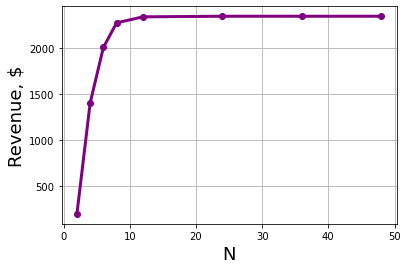

In [23]:
plt.plot(N,rev,'o-',color="purple",linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Revenue, $',fontsize=18)
plt.grid(True)
plt.show()

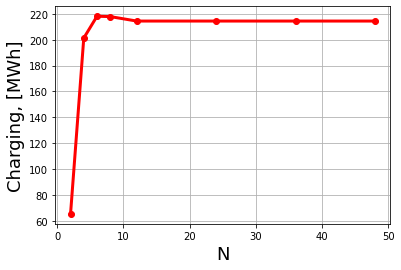

In [24]:
plt.plot(N,charge,'ro-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Charging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

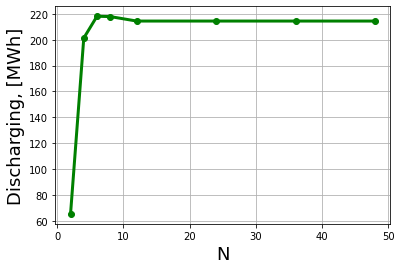

In [25]:
plt.plot(N,discharge,'go-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Discharging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

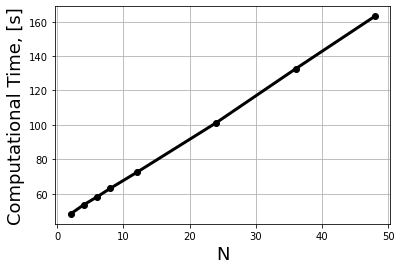

In [26]:
plt.plot(N,timer,'ko-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Computational Time, [s]',fontsize=18)
plt.grid(True)
plt.show()

**Discussion** How long of a simulation horizon do you recommend? Discuss the trade-off between revenue and computation time.

I recommend a simulation horizon of 12 hours.  Computation time increases approximately linearly with horizon length, whereas profit approaches an upper limit, appearing flat after 12 hours.  There is not a lot of profit increase from N = 8 hours to N = 12 hours, but I assume that the ~10 second increase in computational time is cheap compared to the ~$100 increase in profit.  I'm not so sure about longer horizons because I cannot see an increase in profit on the plot past N=12 hours, while computational time steadily increases.  It is also good to note that there appears to be a basic computational time requirement that comes with solving the problem at all, and it is large compared to the additional computational time per hour of horizon length.

### 1.2.3.5 Impact of Periodic Boundary Condition

We will now explore the impact of the periodic boundary constraint.

First, simulate the performance over 3 days **without enforcing the periodic boundary constraint**. Plot the implemented control action and calculate the total revenue. Use $N=4$.

In [27]:
c_control2, d_control2, E_control2, revenue_control2 = receding_horizon_simulation(three_days, 24*3, 4,
                                                                                  include_pbc=False,verbose=True)

Hour 1: -6.661926972264925e-10 MW from grid; battery holding 0.0 MWh
Hour 2: 0.0 MW from grid; battery holding 0.0 MWh
Hour 3: 0.0 MW from grid; battery holding 3.914913834840594e-09 MWh
Hour 4: 1.0 MW from grid; battery holding 0.9380831726863139 MWh
Hour 5: 0.9999999918988141 MW from grid; battery holding 1.876166327181364 MWh
Hour 6: 0.0 MW from grid; battery holding 1.8761663277875535 MWh
Hour 7: -0.7600000264549603 MW from grid; battery holding 1.0660035685620703 MWh
Hour 8: -0.999999987277885 MW from grid; battery holding 0.0 MWh
Hour 9: -9.239351667379078e-10 MW from grid; battery holding 0.0 MWh
Hour 10: -6.578132842611303e-10 MW from grid; battery holding 0.0 MWh
Hour 11: -3.363655203467335e-10 MW from grid; battery holding 0.0 MWh
Hour 12: 0.0 MW from grid; battery holding 0.0 MWh
Hour 13: 0.13636361589547438 MW from grid; battery holding 0.12792042047582 MWh
Hour 14: 1.0 MW from grid; battery holding 1.0660035907994614 MWh
Hour 15: 1.0 MW from grid; battery holding 2.0040867

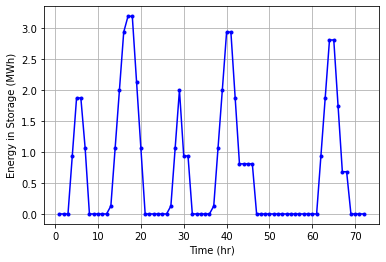

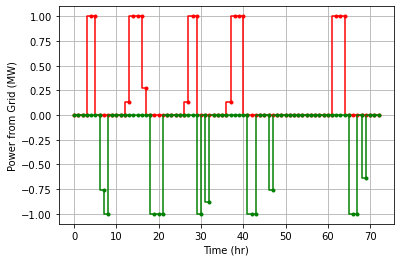

In [28]:
plot_solution(c_control2, d_control2, E_control2)

Next, simulate **with the periodic boundary constraint** using $N=4$. Plot the results.

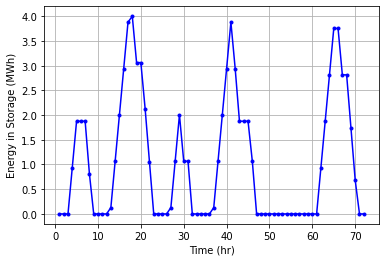

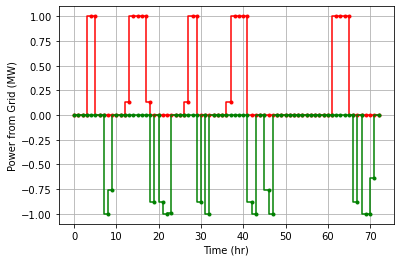

In [29]:
c_control3, d_control3, E_control3, revenue_control3 = receding_horizon_simulation(three_days, 24*3, 4,
                                                                                  include_pbc=True,verbose=False)
plot_solution(c_control3, d_control3, E_control3)

Now let's compare.

In [30]:
# Charge
compare_solutions(c_control2, c_control3)

17 0.27272722447776093 1.0 0.727272775522239
18 0.0 0.1276506393262444 0.1276506393262444
41 0.0 1.0 1.0
65 0.0 1.0 1.0

Total 13.681818037098196 16.5367414950355 2.8549234579373035
Done.


In [31]:
# Discharge
compare_solutions(d_control2, d_control3)

7 0.7600000264549603 0.0 -0.7600000264549603
9 9.239351667379078e-10 0.7600000122070083 0.7600000112830732
19 1.0 0.8800000209270851 -0.11999997907291493
20 0.9999999849995275 0.0 -0.9999999849995275
21 0.9999999980008056 0.8800000229520119 -0.11999997504879378
22 5.487592821604454e-10 1.0 0.9999999994512407
23 9.634038444988661e-10 0.9923325257819202 0.9923325248185164
30 1.0 0.8800000170675548 -0.11999998293244518
32 0.8800000051042807 1.0 0.11999999489571933
42 1.0 0.8799999793691473 -0.12000002063085269
46 0.0 0.7600000090920632 0.7600000090920632
47 0.7599999533684424 1.0 0.2400000466315576
66 1.0 0.0 -1.0
67 1.0 0.880000020903497 -0.11999997909650295
69 0.6400000246305393 1.0 0.3599999753694607
70 6.07719320789031e-10 1.0 0.9999999993922807
71 9.899336778450476e-10 0.6400000091491912 0.6400000081592575

Total 12.040000024994866 14.552332621146741 2.512332596151875
Done.


In [32]:
# Energy
compare_solutions(E_control2, E_control3)

7 1.0660035685620703 1.8761663353429956 0.8101627667809252
8 0.0 0.810162734742196 0.810162734742196
17 3.1980107576900796 3.8802531137541547 0.6822423560640751
18 3.1980107563736717 4.0 0.8019892436263283
19 2.1320071552785977 3.061916816676231 0.9299096613976334
20 1.0660035804771075 3.061916811189158 1.9959132307120506
21 0.0 2.1238336257475945 2.1238336257475945
22 0.0 1.0578300264713258 1.0578300264713258
30 0.938083156177278 1.0660035931169902 0.12792043693971222
31 0.9380831569707564 1.066003593876037 0.12792043690528065
41 2.9421698963630702 3.8802530759819356 0.9380831796188653
42 1.8761662953899492 2.942169937010926 1.0660036416209768
43 0.8101626945060681 1.8761663774734898 1.0660036829674215
44 0.810162670521149 1.8761663769065644 1.0660037063854153
45 0.8101626706148221 1.8761663769829862 1.0660037063681642
46 0.8101626717392068 1.0660036362033445 0.25584096446413773
65 2.8142495234866 3.75233268640087 0.9380831629142699
66 1.7482459228279832 3.7523326864201647 2.004086763

In [33]:
# Profit
compare_solutions(revenue_control2, revenue_control3)

7 29.383121022801674 0.0 -29.383121022801674
9 3.24116456491658e-08 26.66080042822185 26.660800395810206
17 -12.169634210646649 -44.622 -32.45236578935335
18 0.0 -6.504693628147436 -6.504693628147436
19 59.345 52.22360124191786 -7.121398758082137
20 52.56399921151516 0.0 -52.56399921151516
21 52.818999894404556 46.48072121230231 -6.338278682102242
22 2.6788233117944305e-08 48.816 48.81599997321177
23 4.4976508480429565e-08 46.32704396612895 46.32704392115244
30 44.143 38.84584075341307 -5.297159246586929
32 36.30088021055668 41.251 4.95011978944332
41 0.0 -44.137 -44.137
42 51.751 45.54087893233274 -6.210121067667259
46 0.0 33.480280400532656 33.480280400532656
47 35.55203781862237 46.779 11.226962181377637
65 0.0 -42.995 -42.995
66 53.432 0.0 -53.432
67 54.838 48.25744114630597 -6.580558853694029
69 31.397761208349625 49.059 17.661238791650373
70 2.6742080992000516e-08 44.004 44.00399997325792
71 4.1125804712394656e-08 26.588160380093996 26.58816033896819

Total 194.6793963908414 161.

**Discussion** Compare the control actions and revenue with and without the periodic boundary constraint. How are they different (if at all)? Offer an explanation for any differences. (The purpose of this questions is to get you thinking about how to critically analyze the optimization results. This skill will be really important for the semester projects.)

The battery is more active (charges and discharges more) in order to satisfy the periodic boundary constraint, and also makes less profit than without pbc, which makes sense because pbc forces the battery to completely empty at the end of the horizon whether that's beneficial or not.

Next, repeat the horizon length sensitivity analysis without the peridoic boundary constraint.

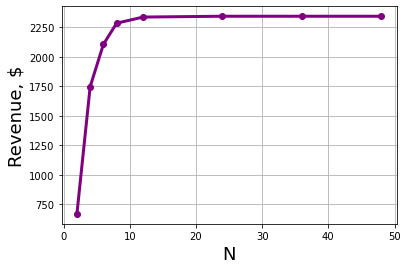

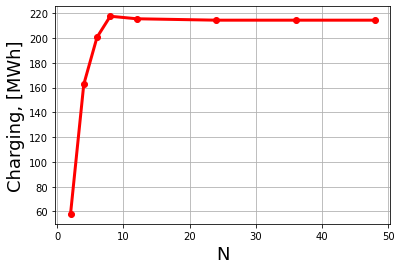

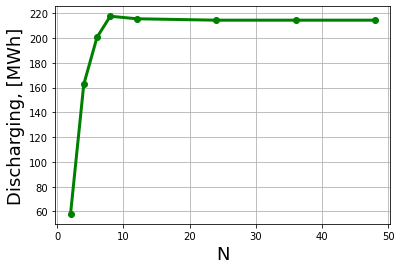

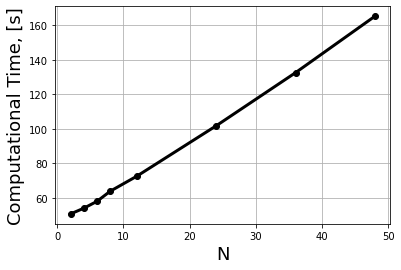

In [34]:
# Begin Solution
rev2 = []
charge2 = []
discharge2 = []
timer2 = []


N = [2, 4, 6, 8, 12, 24, 36, 48]


for hlen in N: # remove slice once finished initial testing
    time_start = time.perf_counter()
    c_control_N, d_control_N, E_control_N, revenue_control_N = receding_horizon_simulation(first_month, 24*30, 
                                                                                   hlen, include_pbc=False,
                                                                                  verbose=False)
    time_elapsed = (time.perf_counter() - time_start)
    # append results
    charge2.append(sum(c_control_N))
    discharge2.append(sum(c_control_N))
    timer2.append(time_elapsed)
    rev2.append(np.dot(d_control_N-c_control_N, first_month[:24*30])) # assuming net revenue, which is profit
    
plt.plot(N,rev2,'o-',color="purple",linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Revenue, $',fontsize=18)
plt.grid(True)
plt.show()

plt.plot(N,charge2,'ro-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Charging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

plt.plot(N,discharge2,'go-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Discharging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

plt.plot(N,timer2,'ko-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Computational Time, [s]',fontsize=18)
plt.grid(True)
plt.show()



In [35]:
# Profit
compare_solutions(rev, rev2)

1 193.96611232381935 667.3327191236971 473.36660679987773
2 1400.5830353917218 1746.1764307512906 345.59339535956883
3 2004.4374619567957 2105.040838447384 100.60337649058829
4 2272.0638502382626 2284.5143850670433 12.450534828780746
5 2337.10606505579 2336.7661350833637 -0.33992997242648926

Total 15238.97162916117 16170.645611963555 931.6739828023856
Done.


In [36]:
# Time
compare_solutions(timer, timer2)

1 48.27001880000171 50.67422879999867 2.404209999996965
2 53.59555210000326 53.96410710000055 0.36855499999728636
3 58.14127860000008 57.9671296000015 -0.1741489999985788
4 63.08906279999792 63.830990599999495 0.7419278000015765
5 72.38276000000042 72.48941280000145 0.10665280000102939
6 101.18214250000165 101.68549930000154 0.5033567999998922
7 132.5065577000023 132.46773190000022 -0.03882580000208691
8 163.08569699999862 165.16419560000213 2.0784986000035133

Total 692.253069500006 698.2432957000055 5.990226199999597
Done.


**Discussion** Compare these result to the analysis with periodic boundary constraints. Based on these results, make a recommendation to a battery operator.

These results show more profit for slightly less computational time.  I recommend optimizing without periodic boundary constraints.

## 1.2.4 Forecast Uncertainty (required for CBE 60499, optional for CBE 40499)

So far, we have assumed the battery operator can perfectly forecast the market price. This is not realistic. What is the impact of uncertainty?

Generate white noise with mean zero and standard deviation 5 \$/MWh using `np.random.normal()` and add this to the historical price. We will treat this as a price forecast. Simulate the first three days with $N=24$. Calculate how much less revenue you make with price uncertainty compared to the perfect information case. *Hint:* Each time you run the simulation, you will get a different answer. Repeat the analysis 10 times and record the average.

**Are you enrolled in CBE 60499** (are you a graduate student)? Please answer yes/no:

In [37]:
revenue_unc_predicted = []
revenue_unc_actual = []

# Perform simulation with perfect information
c_control, d_control, E_control, revenue_control = receding_horizon_simulation(three_days, 
                                                                                       24*3, 24, include_pbc=True,
                                                                                  verbose=False)
# We can also calculate the revenue after the fact
rev_check = 0
for t in range(len(c_control)):
    # Why is this slightly different? In the instructor/TA solutions for receding_horizon_simulation,
    # we added a negative sign to d_control for plotting.----- But I applied the negative sign in the plot command
    rev_check +=  three_days[t]*(d_control[t] - c_control[t])

revenue_perfect_information = np.sum(revenue_control)
print("Revenue with perfect price forecast =",revenue_perfect_information,"=",rev_check,"$")

# Tip: normalize the revenue from the uncertain simulations by `revenue_perfect_information`
# This will make the interpretation much easier!

n = len(three_days)
nsim = 10

for i in range(nsim):

    # Add random noise to data
    three_days_with_noise = three_days + 5*np.random.normal(size=n)

    # Start Solution
    c_control_noisy, d_control_noisy, E_control_noisy, revenue_control_noisy = receding_horizon_simulation(three_days_with_noise, 
                                                                                       24*3, 24, include_pbc=True,
                                                                                  verbose=False)
    revenue_unc_predicted.append(np.dot(d_control_noisy-c_control_noisy,three_days_with_noise[:24*3]))
    revenue_unc_actual.append(np.dot(d_control_noisy-c_control_noisy,three_days[:24*3]))
    # End solution
    
print("Average Revenue =",np.mean(revenue_unc_actual)/revenue_perfect_information*100,"%")

Revenue with perfect price forecast = 263.82641004995526 = 263.8264100499552 $
Average Revenue = 71.68876772907672 %


**Discussion** Compare the results with your earlier analysis. How much less revenue do you get with Gaussian noise with standard deviation 5 $/MWh.

I get approximately 30\% less revenue, in this instance about 28.3\% less.

Next, make a plot showing the average revenue as a function of the standard deviation of the uncertainty. *Hint*: Normalize the revenue by dividing by the perfect information revenue (no uncertainty).

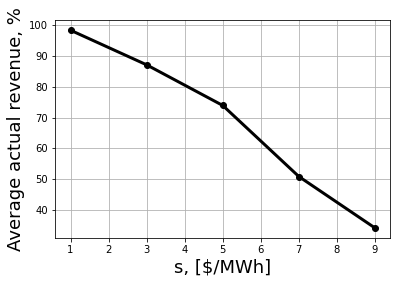

In [38]:
# Start Solution
meanrev = []

n = len(three_days)
nsim = 10

# list of standard deviations of uncertainty
slist = [1, 3, 5, 7, 9]

for s in slist:
    for i in range(nsim):
        revenue_unc_predicted_s = []
        revenue_unc_actual_s = []
        # Add random noise to data
        three_days_with_noise_s = three_days + s*np.random.normal(size=n)
        # Start Solution
        c_control_noisy_s, d_control_noisy_s, E_control_noisy_s, revenue_control_noisy_s = receding_horizon_simulation(three_days_with_noise_s, 
                                                                                           24*3, 24, include_pbc=True,
                                                                                      verbose=False)
        revenue_unc_predicted_s.append(np.dot(d_control_noisy_s-c_control_noisy_s,three_days_with_noise_s[:24*3]))
        revenue_unc_actual_s.append(np.dot(d_control_noisy_s-c_control_noisy_s,three_days[:24*3]))
    meanrev.append(np.mean(revenue_unc_actual_s)/revenue_perfect_information*100)

plt.plot(slist,meanrev,'ko-',linewidth=3)
plt.xlabel('s, [$/MWh]',fontsize=18)
plt.ylabel('Average actual revenue, %',fontsize=18)
plt.grid(True)
plt.show()

**Discussion** What is the impact with the larger uncertainty?

Profit decreases with larger uncertainty.

**Discussion** Why does uncertainty in the price decrease the revenue (on average)?

The uncertainty in the price decreases the revenue because the forcast best times and amounts to buy and sell are different from the actual best times to buy and sell.

<!--NAVIGATION-->
< [1.1 60 Minutes to Pyomo: An Energy Storage Model Predictive Control Example](https://ndcbe.github.io/CBE60499/01.01-Pyomo-Nuts-and-Bolts.html) | [Contents](toc.html) | [2.0 Optimization Modeling with Applications](https://ndcbe.github.io/CBE60499/02.00-Optimization-Modeling.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/01.02-Pyomo-Mini-Project.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>